In [2]:
G_path = './Project_Data'
import pandas as pd
import seaborn as sns
from sklearn import *
import sklearn as sk
from sklearn import *
import numpy as np
from datetime import datetime	
from scipy.stats import chi2_contingency
import datetime as dt
import pickle

import json
import random
import scipy as sp
import seaborn as sns

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from statistics import mean
import warnings
warnings.filterwarnings('ignore')
import features
from features.usefull_functions import *
from features.NETs import *
from features.Model_Training import *
pd.get_option("display.max_columns")
date_hour = datetime.now().strftime("%d_%b%y_%H_%M")

In [30]:
# %%time
image_label = 'image_label'  #[image_label, binary_label]
select_features = False
remove_All_augmented = False
remove_wrong_cnn_predictions = False


file = 'CNN_360x270_Ouput_MultiClass_SoftMax' #[ CNN_360x270_Ouput_Binary_SoftMax, CNN_360x270_Ouput_MultiClass_SoftMax, CNN_280x210_Ouput_MultiClass,CNN_280x210_Ouput_MultiClass_SoftMax,CNN_280x210_Ouput_MultiClass_NoSoftMax,CNN_280x210_Ouput_MultiClass_Scaled]

data = pd.read_pickle(G_path + '/07_CNNs_Output_DataSet/' + file)

blc_test_list = pickle.load(open(G_path + '/02_Augmented_MetaData/balanced_test_set','rb'))

if remove_All_augmented:
    data = data[~data.image_id.str.contains('AUG')]

blc_test_list = pickle.load(open(G_path + '/02_Augmented_MetaData/balanced_test_set','rb'))
# Evaluation_set = pickle.load(open(G_path + '/DataSet_280x210/' + file,'rb'))


cols_remove = ['image_id','image_label','dx','lesion_id','type','binary_label','label_description']
# cols_remove = ['image_id','image_label','dx','lesion_id','type','binary_label']

selected_feature = ['CNN_0','CNN_1','CNN_2','CNN_3','CNN_4','CNN_5','CNN_6','age','dx_type_consensus','dx_type_follow_up','dx_type_histo']
cnn_ = ['CNN_0','CNN_1','CNN_2','CNN_3','CNN_4','CNN_5','CNN_6']



train_data = data[data.type=='train']
if remove_wrong_cnn_predictions:

    print('train initial shape: ', train_data.shape)
    train_data['cnn_label'] = train_data[cnn_].apply(lambda x : np.array(x[cnn_]).argmax(),axis=1)
    train_data = train_data[train_data.cnn_label == train_data.image_label]
    train_data.drop(columns=['cnn_label'],inplace=True)
    print('train removed wrong CNN shape: ',train_data.shape)

valid_data = data[data.type=='valid']
test_data = data[data.type=='test']
blc_test_data = data.merge(blc_test_list['image_id'], how='inner',on='image_id')



train_label = train_data[image_label]
train_data = train_data.drop(columns= cols_remove)
valid_label = valid_data[image_label]
valid_data = valid_data.drop(columns=cols_remove)
test_label = test_data[image_label]
test_data = test_data.drop(columns=cols_remove)
blc_label = blc_test_data[image_label]
blc_data = blc_test_data.drop(columns=cols_remove)

if select_features:
    train_data = train_data[selected_feature]
    valid_data = valid_data[selected_feature]
    test_data = test_data[selected_feature]
    blc_data = blc_test_data[selected_feature]


train_data_arrays = np.stack(train_data.values)  
train_label_arrays = np.stack(train_label.values)
train_label_arrays_One = pd.get_dummies(train_label_arrays).values  

valid_data_arrays = np.stack(valid_data.values)  
valid_label_arrays = np.stack(valid_label.values)  
valid_label_arrays_One = pd.get_dummies(valid_label_arrays).values  

test_data_arrays = np.stack(test_data.values)  
test_label_arrays = np.stack(test_label.values)  
test_label_arrays_One = pd.get_dummies(test_label_arrays).values  

blc_data_arrays = np.stack(blc_data.values)  
blc_label_arrays = np.stack(blc_label.values)  
blc_label_arrays_One = pd.get_dummies(blc_label_arrays).values 

#Numpy Arrays
input_data_Array = (train_data_arrays , valid_data_arrays, test_data_arrays , np.concatenate((train_data_arrays,valid_data_arrays )))
labels_Array = (train_label_arrays,valid_label_arrays,test_label_arrays, np.concatenate((train_label_arrays,valid_label_arrays)))
labels_One_Array = (train_label_arrays_One,valid_label_arrays_One,test_label_arrays_One, np.concatenate((train_label_arrays_One,valid_label_arrays_One)))

# Tensors
def to_Torch(x):
    return torch.tensor(x,dtype= torch.float32)

input_data_Tensor = (to_Torch(train_data_arrays),to_Torch(valid_data_arrays)  , to_Torch(test_data_arrays) , to_Torch(np.concatenate((train_data_arrays,valid_data_arrays))))
labels_Tensor = (to_Torch(train_label_arrays),to_Torch(valid_label_arrays),to_Torch(test_label_arrays) , to_Torch(np.concatenate((train_label_arrays,valid_label_arrays))) )
labels_OneHot_Tensor = (to_Torch(train_label_arrays_One),to_Torch(valid_label_arrays_One),to_Torch(test_label_arrays_One), to_Torch(np.concatenate((train_label_arrays_One,valid_label_arrays_One))))

blc_data_Tensor = (to_Torch(blc_data_arrays))

print('Train set shape: ', train_data_arrays.shape)

Train set shape:  (4993, 30)


In [31]:
Aug_list = data[data.image_id.str.contains('AUG')][['image_id','image_label']]
Aug_list['image_id'] = Aug_list['image_id'].str.replace('AUG1_','').str.replace('AUG2_','').str.replace('AUG3_','')
Aug_list[['image_id','image_label']].value_counts()

image_id      image_label
ISIC_0024318  3              3
ISIC_0029860  0              3
ISIC_0030233  1              3
ISIC_0030244  3              3
ISIC_0030249  1              3
                            ..
ISIC_0027294  0              3
ISIC_0027297  1              3
ISIC_0027303  0              3
ISIC_0027334  0              3
ISIC_0034306  1              3
Length: 580, dtype: int64

In [32]:
id = 'ISIC_0034306'
cnn_ = [x for x in data.columns if 'CNN_' in x] 
cols = cnn_ + [image_label, 'image_id']
aug_details = data[data.image_id.str.contains(id)][cols]
aug_details['predicted'] = aug_details.apply(lambda x: np.array(x[cnn_]).argmax(),axis=1)
aug_details

,CNN_0,CNN_1,CNN_2,CNN_3,CNN_4,CNN_5,CNN_6,image_label,image_id,predicted
1565,0.000094,0.999364,5.916592e-11,4.552321e-06,0.000007,0.000017,0.000514,1,AUG1_ISIC_0034306,1
2473,0.000005,0.999753,1.285585e-08,2.321476e-06,0.000007,0.000072,0.000161,1,AUG2_ISIC_0034306,1
3366,0.000001,0.997795,7.020980e-09,4.148506e-07,0.000197,0.001815,0.000192,1,ISIC_0034306,1
4052,0.000019,0.999728,7.517908e-10,2.255077e-05,0.000017,0.000008,0.000205,1,AUG3_ISIC_0034306,1


In [33]:
train_label_arrays, train_data['CNN_0'].max() , input_data_Array[0].shape

(array([2, 1, 1, ..., 4, 3, 5], dtype=int8), 0.99999654, (4993, 30))

# **Guassian NB**

In [34]:

Model_ = sk.naive_bayes.GaussianNB()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
kflods = sk.model_selection.StratifiedKFold(n_splits=30, shuffle=True)
cross_valid = False
save_model = True
nr_repeat = 50

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

if np.unique(Y_valid).shape[0] == 2:
    name = 'binary_'
else:
    name = 'multi_'

grid = { 
    'priors': [None],
    'var_smoothing': [0,4e-1,5e-1,3e-1,2e-1,0.5e-1, 1e-3, 1e-4, 1e-5]
}

# grid = { 
#     'priors': [None],
#     'var_smoothing': [3e-1]
# }

GB_Model, GB_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat,best_selection='recall' )

# date_hour = datetime.now().strftime("%d_%b%y_%H_%M")
if save_model:
    pickle.dump(GB_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'GB_Model_' +name+ date_hour , 'wb'))

 Max_Valid_Acc.: 75.2%, Max_Test_Acc.: 71.7%, Expected_test_Acc.: 71.0% [██████████████████████████████] 450/450 [Time => Iter.: 0.0s, Tot.: 2.9s, Remain.: 0.0s]    
------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.50      0.52      0.51        23
           1       0.51      0.69      0.59        32
           2       0.58      0.62      0.60        72
           3       0.80      0.50      0.62         8
           4       0.49      0.63      0.55        62
           5       0.93      0.79      0.86       200
           6       0.90      0.90      0.90        10

    accuracy                           0.71       407
   macro avg       0.67      0.66      0.66       407
weighted avg       0.74      0.71      0.72       407

Best param:  {'priors': None, 'var_smoothing': 0.001}


Nr. of Data : 
 105
Accuracy of The Model : 
 0.5714285714285714


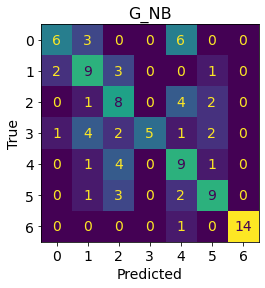

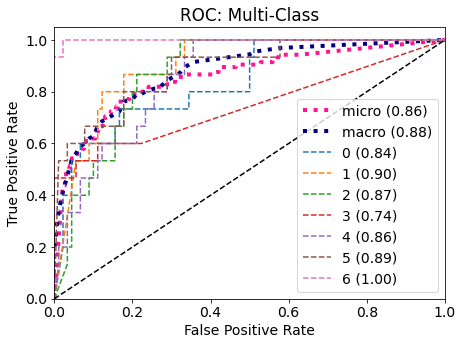

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,14.3%,66.7%,40.0%,96.7%,50.0%
1,14.3%,47.4%,60.0%,88.9%,52.9%
2,14.3%,40.0%,53.3%,86.7%,45.7%
3,14.3%,100.0%,33.3%,100.0%,50.0%
4,14.3%,39.1%,60.0%,84.4%,47.4%
5,14.3%,60.0%,60.0%,93.3%,60.0%
6,14.3%,100.0%,93.3%,100.0%,96.6%
Simple Avg.,nan%,64.7%,57.1%,92.9%,57.5%
Weighted Avg.,nan%,64.7%,57.1%,92.9%,57.5%


In [35]:
# Model 280x210
Balanced_Test_set = True 
Multi_to_binary = False
print_AUC_ROC = True
title = 'G_NB'

model = GB_Model  # {RF_Model,SVM_Model,GB_Model,MLP_Model,KNN_Model,Biased_Model}

if Balanced_Test_set:
    X = blc_data_arrays
    Y = blc_label_arrays
else:
    X = input_data_Array[2]
    Y = labels_Array[2]

Y_pred = model.predict(X)
Y_pred_prob = model.predict_proba(X)
if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    results = model_evaluation(Y_binary,Y_pred_binary,title)
else:
    results = model_evaluation(Y,Y_pred,title)

if print_AUC_ROC:
    Y_OneH = np.eye(np.unique(Y).shape[0])[Y]
    fpr, tpr, roc_auc = fpr_tpr_score(Y_OneH,Y_pred_prob)
    plot_roc_auc_multi(fpr, tpr, roc_auc)

results

# **Random Forrest**

In [46]:
Model_ = sk.ensemble.RandomForestClassifier( n_jobs=-1)
# kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
kflods = sk.model_selection.StratifiedKFold(n_splits=20, shuffle=True)

cross_valid = False
save_model = True
nr_repeat = 2

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

if np.unique(Y_valid).shape[0] == 2:
    name = 'binary_'
else:
    name = 'multi_'


grid = { 
    'n_estimators': [50,100,200],
    'max_features': ['log2','auto'],
    'max_depth' : [10,20,30],
    'min_samples_leaf': [2,10],
    'criterion' :[ 'gini','entropy'],
    'bootstrap': [False,True],
    'class_weight' : [None,'balanced'],
    'max_leaf_nodes' : [None],
    'max_features' : ['log2', None]
}

RF_Model, RF_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat,best_selection='recall')

# date_hour = datetime.now().strftime("%d_%b%y_%H_%M")
if save_model:
    pickle.dump(RF_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'RF_Model_' + name +date_hour , 'wb'))

 Max_Valid_Acc.: 74.9%, Max_Test_Acc.: 73.5%, Expected_test_Acc.: 72.7% [██████████████████████████████] 576/576 [Time => Iter.: 0.5s, Tot.: 140.5s, Remain.: 0.0s]     
------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.52      0.65      0.58        23
           1       0.55      0.75      0.63        32
           2       0.62      0.67      0.64        72
           3       1.00      0.50      0.67         8
           4       0.52      0.47      0.49        62
           5       0.89      0.83      0.86       200
           6       0.90      0.90      0.90        10

    accuracy                           0.73       407
   macro avg       0.71      0.68      0.68       407
weighted avg       0.74      0.73      0.73       407

Best param:  {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'n_estimators': 50}


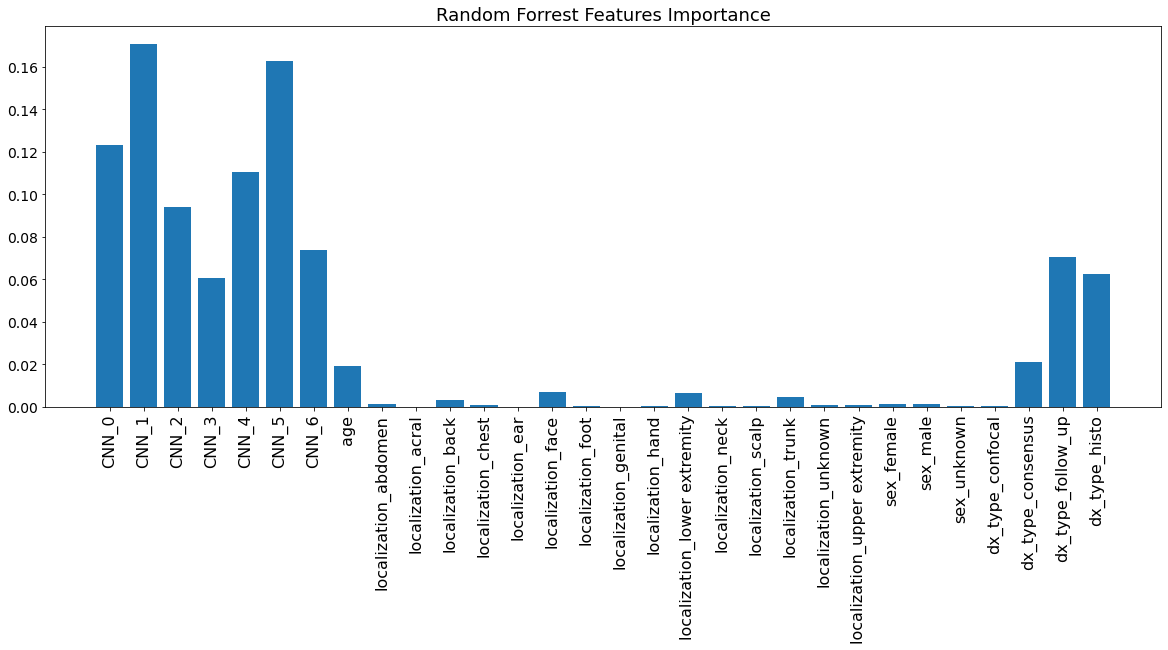

In [47]:
importance = RF_Model.feature_importances_

features_name = list(train_data.columns)
plt.subplots(figsize=(20,7))
plt.bar(features_name, importance)
plt.xticks(fontsize=16, rotation=90)
plt.title('Random Forrest Features Importance',fontsize = 18)
plt.show()

Nr. of Data : 
 407
Accuracy of The Model : 
 0.7272727272727273


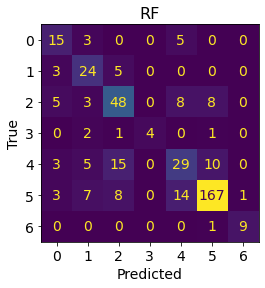

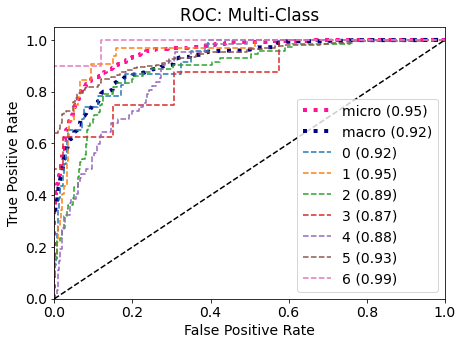

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,51.7%,65.2%,96.4%,57.7%
1,7.9%,54.5%,75.0%,94.7%,63.2%
2,17.7%,62.3%,66.7%,91.3%,64.4%
3,2.0%,100.0%,50.0%,100.0%,66.7%
4,15.2%,51.8%,46.8%,92.2%,49.2%
5,49.1%,89.3%,83.5%,90.3%,86.3%
6,2.5%,90.0%,90.0%,99.7%,90.0%
Simple Avg.,nan%,71.4%,68.2%,94.9%,68.2%
Weighted Avg.,nan%,74.2%,72.7%,91.9%,73.0%


In [48]:
# Model 280x210
Balanced_Test_set = False 
Multi_to_binary = False
print_AUC_ROC = True
title = 'RF'

model = RF_Model  # {RF_Model,SVM_Model,GB_Model,MLP_Model,KNN_Model,Biased_Model}

if Balanced_Test_set:
    X = blc_data_arrays
    Y = blc_label_arrays
else:
    X = input_data_Array[2]
    Y = labels_Array[2]

Y_pred = model.predict(X)
Y_pred_prob = model.predict_proba(X)
if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    results = model_evaluation(Y_binary,Y_pred_binary,title)
else:
    results = model_evaluation(Y,Y_pred,title)

if print_AUC_ROC:
    Y_OneH = np.eye(np.unique(Y).shape[0])[Y]
    fpr, tpr, roc_auc = fpr_tpr_score(Y_OneH,Y_pred_prob)
    plot_roc_auc_multi(fpr, tpr, roc_auc)

results

# **SVM**

In [39]:
Model_ = sk.svm.SVC()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
kflods = sk.model_selection.StratifiedKFold(n_splits=25, shuffle=True)
cross_valid = False
save_model = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

if np.unique(Y_valid).shape[0] == 2:
    name = 'binary_'
else:
    name = 'multi_'

grid = { 
    'C' : [7,8,10]
    ,'kernel': ['rbf', 'linear'],
    'degree' : [1,2,3],
    'gamma' :['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr'],
    'class_weight' : [None, 'balanced']
}

SVM_Model, SVM_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)


if save_model:
    pickle.dump(SVM_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'SVM_Model_' + name +date_hour , 'wb'))
    

 Max_Valid_Acc.: 74.7%, Max_Test_Acc.: 73.2%, Expected_test_Acc.: 72.2% [██████████████████████████████] 144/144 [Time => Iter.: 0.1s, Tot.: 15.7s, Remain.: 0.0s]    
------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.65      0.57      0.60        23
           1       0.55      0.69      0.61        32
           2       0.60      0.67      0.63        72
           3       0.67      0.50      0.57         8
           4       0.47      0.45      0.46        62
           5       0.89      0.85      0.87       200
           6       0.90      0.90      0.90        10

    accuracy                           0.72       407
   macro avg       0.68      0.66      0.66       407
weighted avg       0.73      0.72      0.72       407

Best param:  {'C': 7, 'class_weight': None, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Nr. of Data : 
 105
Accuracy of The Model : 
 0.8476190476190476


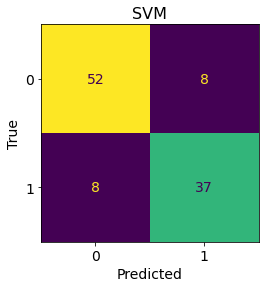

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,57.1%,86.7%,86.7%,82.2%,86.7%
1,42.9%,82.2%,82.2%,86.7%,82.2%
Simple Avg.,nan%,84.4%,84.4%,84.4%,84.4%
Weighted Avg.,nan%,84.8%,84.8%,84.1%,84.8%


In [21]:
# Model 280x210
Balanced_Test_set = True 
Multi_to_binary = False
title = 'SVM'

model = SVM_Model  # {RF_Model,SVM_Model,GB_Model,MLP_Model,KNN_Model,Biased_Model}

if Balanced_Test_set:
    X = blc_data_arrays
    Y = blc_label_arrays
else:
    X = input_data_Array[2]
    Y = labels_Array[2]

Y_pred = model.predict(X)

if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    results = model_evaluation(Y_binary,Y_pred_binary,title)
else:
    results = model_evaluation(Y,Y_pred,title)


results

# **MLP**

In [40]:
Model_ = sk.neural_network.MLPClassifier()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
kflods = sk.model_selection.StratifiedKFold(n_splits=25, shuffle=True)
cross_valid = False
save_model = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

if np.unique(Y_valid).shape[0] == 2:
    name = 'binary_'
else:
    name = 'multi_'

grid = {
    'hidden_layer_sizes': [(50,60,50),(40,70,40)],
    'random_state':[0],
    'activation': [ 'relu'],
    'solver': ['sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['adaptive'],
    'learning_rate_init' : [1e-3,1.5e-3]
}

MLP_Model, MLP_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)


if save_model:
    pickle.dump(MLP_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'MLP_Model_' + name +date_hour , 'wb'))


 Max_Valid_Acc.: 75.4%, Max_Test_Acc.: 72.5%, Expected_test_Acc.: 71.7% [██████████████████████████████] 8/8 [Time => Iter.: 9.5s, Tot.: 84.8s, Remain.: 0.0s]      
------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.55      0.52      0.53        23
           1       0.53      0.75      0.62        32
           2       0.64      0.67      0.65        72
           3       0.57      0.50      0.53         8
           4       0.49      0.47      0.48        62
           5       0.88      0.83      0.85       200
           6       0.90      0.90      0.90        10

    accuracy                           0.72       407
   macro avg       0.65      0.66      0.65       407
weighted avg       0.73      0.72      0.72       407

Best param:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 60, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'random_state': 0, 'solver': 'sgd'}


Nr. of Data : 
 105
Accuracy of The Model : 
 0.8380952380952381


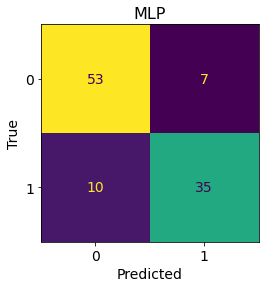

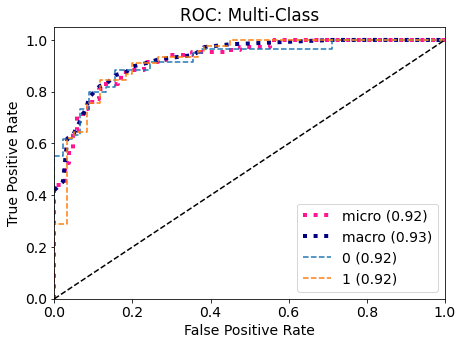

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,57.1%,84.1%,88.3%,77.8%,86.2%
1,42.9%,83.3%,77.8%,88.3%,80.5%
Simple Avg.,nan%,83.7%,83.1%,83.1%,83.3%
Weighted Avg.,nan%,83.8%,83.8%,82.3%,83.7%


In [23]:
# Model 280x210
Balanced_Test_set = True 
Multi_to_binary = False
print_AUC_ROC = True
title = 'MLP'

model = MLP_Model  # {RF_Model,SVM_Model,GB_Model,MLP_Model,KNN_Model,Biased_Model}

if Balanced_Test_set:
    X = blc_data_arrays
    Y = blc_label_arrays
else:
    X = input_data_Array[2]
    Y = labels_Array[2]

Y_pred = model.predict(X)
Y_pred_prob = model.predict_proba(X)
if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    results = model_evaluation(Y_binary,Y_pred_binary,title)
else:
    results = model_evaluation(Y,Y_pred,title)

if print_AUC_ROC:
    Y_OneH = np.eye(np.unique(Y).shape[0])[Y]
    fpr, tpr, roc_auc = fpr_tpr_score(Y_OneH,Y_pred_prob)
    plot_roc_auc_multi(fpr, tpr, roc_auc)

results

# **KNN**

In [41]:
Model_ = neighbors.KNeighborsClassifier(n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
kflods = sk.model_selection.StratifiedKFold(n_splits=25, shuffle=True)
cross_valid = False
save_model = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

if np.unique(Y_valid).shape[0] == 2:
    name = 'binary_'
else:
    name = 'multi_'
    
grid = { 
    'n_neighbors': [7,8,12,16],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'leaf_size' : [15,20,25],
    'p' : [1,2,5]
}

# grid = { 
#     'n_neighbors': [8],
#     'weights': ['distance'],
#     'algorithm': ['auto'],
#     'leaf_size' : [25],
#     'p' : [2]
# }

KNN_Model, KNN_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(KNN_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'KNN_Model_' + name + date_hour , 'wb'))

 Max_Valid_Acc.: 76.2%, Max_Test_Acc.: 74.0%, Expected_test_Acc.: 73.2% [██████████████████████████████] 288/288 [Time => Iter.: 0.1s, Tot.: 20.6s, Remain.: 0.0s]     
------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.55      0.52      0.53        23
           1       0.56      0.78      0.65        32
           2       0.67      0.69      0.68        72
           3       0.71      0.62      0.67         8
           4       0.46      0.44      0.45        62
           5       0.91      0.85      0.88       200
           6       0.75      0.90      0.82        10

    accuracy                           0.73       407
   macro avg       0.66      0.69      0.67       407
weighted avg       0.74      0.73      0.73       407

Best param:  {'algorithm': 'auto', 'leaf_size': 15, 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}


Nr. of Data : 
 105
Accuracy of The Model : 
 0.6095238095238096


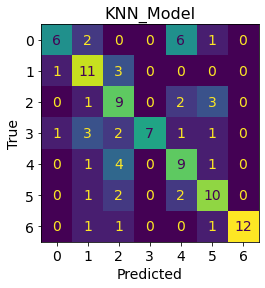

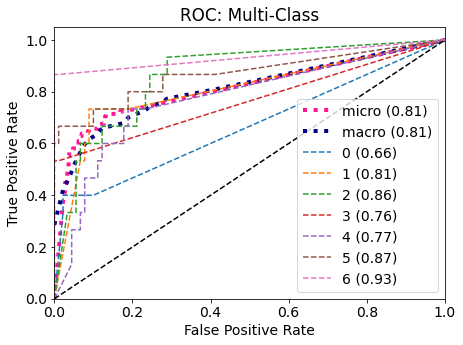

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,14.3%,75.0%,40.0%,97.8%,52.2%
1,14.3%,55.0%,73.3%,90.0%,62.9%
2,14.3%,42.9%,60.0%,86.7%,50.0%
3,14.3%,100.0%,46.7%,100.0%,63.6%
4,14.3%,45.0%,60.0%,87.8%,51.4%
5,14.3%,58.8%,66.7%,92.2%,62.5%
6,14.3%,100.0%,80.0%,100.0%,88.9%
Simple Avg.,nan%,68.1%,61.0%,93.5%,61.6%
Weighted Avg.,nan%,68.1%,61.0%,93.5%,61.6%


In [42]:
# Model 280x210
Balanced_Test_set = True 
Multi_to_binary = False
print_AUC_ROC = True
title = 'KNN_Model'

model = KNN_Model  # {RF_Model,SVM_Model,GB_Model,MLP_Model,KNN_Model,Biased_Model}

if Balanced_Test_set:
    X = blc_data_arrays
    Y = blc_label_arrays
else:
    X = input_data_Array[2]
    Y = labels_Array[2]

Y_pred = model.predict(X)
Y_pred_prob = model.predict_proba(X)
if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    results = model_evaluation(Y_binary,Y_pred_binary,title)
else:
    results = model_evaluation(Y,Y_pred,title)

if print_AUC_ROC:
    Y_OneH = np.eye(np.unique(Y).shape[0])[Y]
    fpr, tpr, roc_auc = fpr_tpr_score(Y_OneH,Y_pred_prob)
    plot_roc_auc_multi(fpr, tpr, roc_auc)

results

# **Ensemble**

In [43]:

def ensemble_models(models, X , Ensemble_details  ):

    best_overall_model = Ensemble_details[Ensemble_details.class_=='Weighted Avg.']['model'].iloc[0]
    Ensemble_details = Ensemble_details[~Ensemble_details['class_'].str.contains('Avg.',na=False)]
    class_models = Ensemble_details[['class_','model']]
    best_models = list(set(class_models.model))


    Y_pred = []
    for j in range(X.shape[0]):
        X_ = X[j:j+1]
        Y_pred__ = None
        # print('Real label: ', Y[j])
        for i in range(0, len(models)):
            if i in best_models:
                Y_pred_ = models[i].predict(X_)[0]
                # print( f'Model_{i} predictions: {Y_pred_}')
                # print(f'Model_{i}_best_class: {class_models[class_models.model==i].class_.to_list()}')
                if Y_pred_ in class_models[class_models.model==i]['class_'].to_list():
                    Y_pred__ = Y_pred_
                    
                    break
        if Y_pred__ == None:
            # print('Y_pred__: ',Y_pred__)
            # print('koo')
            Y_pred_ = models[best_overall_model].predict(X_)[0]
            Y_pred.append(Y_pred_)
            # print('...=> ', Y_pred_)
        else:
            Y_pred.append(Y_pred__)
            # print('ok')
    return Y_pred

In [44]:
models = [RF_Model,SVM_Model,GB_Model,KNN_Model,MLP_Model]
Multi_to_binary = False
X = input_data_Array[1]
Y = labels_Array[1]


classes = np.unique(Y).tolist()
Ensemble_details = pd.DataFrame()

for i in range(0, len(models)):
    Y_pred = models[i].predict(X)
    if Multi_to_binary:
        Y_binary =  label_to_binary(Y)
        Y_pred_binary =  label_to_binary(Y_pred)
        details_ =  recall_specificity(Y_binary, Y_pred_binary)
    else:
        details_ =  recall_specificity(Y, Y_pred)
    details_.reset_index(inplace=True)
    # details_.rename(columns={'index':'class'},inplace=True)
    details_['class_'] = details_['index']
    details_['model'] = i
    Ensemble_details = pd.concat([Ensemble_details,details_],axis=0)
Ensemble_details = Ensemble_details.sort_values(['class_','Recall_Sensitivity'],ascending=[True,False]).groupby('class_').head(1).reset_index()
print('##########################')
print(Ensemble_details[['class_','model']])
print('##########################')
Ensemble_details


##########################
          class_  model
0              0      0
1              1      3
2              2      3
3              3      3
4              4      2
5              5      3
6              6      0
7    Simple Avg.      4
8  Weighted Avg.      3
##########################


,level_0,index,0,1,2,3,4,5,6,weights,Precision,Recall_Sensitivity,Specificity,f1_score,class_,model
0,0,0,11.0,5.0,4.0,1.0,2.0,0.0,0.0,0.056511,0.366667,0.478261,0.950521,0.415094,0,0
1,1,1,8.0,19.0,3.0,1.0,1.0,1.0,0.0,0.081081,0.558824,0.575758,0.959893,0.567164,1,3
2,2,2,1.0,5.0,52.0,0.0,7.0,4.0,4.0,0.179361,0.641975,0.712329,0.913174,0.675325,2,3
3,3,3,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.017199,0.500000,0.285714,0.995000,0.363636,3,3
4,4,4,3.0,0.0,5.0,0.0,46.0,6.0,1.0,0.149877,0.638889,0.754098,0.924855,0.691729,4,2
5,5,5,0.0,3.0,8.0,0.0,7.0,181.0,1.0,0.491400,0.923469,0.905000,0.927536,0.914141,5,3
6,6,6,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.024570,0.909091,1.000000,0.997481,0.952381,6,0
7,7,Simple Avg.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.664291,0.634702,0.953047,0.636792,Simple Avg.,4
8,8,Weighted Avg.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.764277,0.761671,0.935546,0.761429,Weighted Avg.,3


Nr. of Data : 
 105
Accuracy of The Model : 
 0.6476190476190476


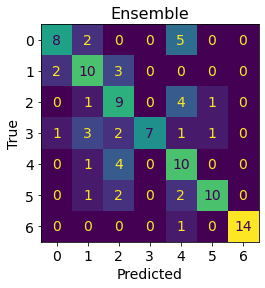

In [45]:
Multi_to_binary = False
X = input_data_Array[1]
Y = labels_Array[1]
X = blc_data_arrays
Y = blc_label_arrays
Y_pred = ensemble_models(models=models, X=X, Ensemble_details=Ensemble_details )

if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    model_evaluation(Y_binary,Y_pred_binary)
else:
    model_evaluation(Y, Y_pred,'Ensemble')


Nr. of Data : 
 105
Accuracy of The Model : 
 0.8476190476190476


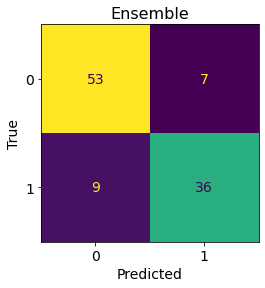

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,57.1%,85.5%,88.3%,80.0%,86.9%
1,42.9%,83.7%,80.0%,88.3%,81.8%
Simple Avg.,nan%,84.6%,84.2%,84.2%,84.4%
Weighted Avg.,nan%,84.7%,84.8%,83.6%,84.7%


In [112]:
# model_evaluation(Y_binary,Y_pred_binary)
model_evaluation(Y, Y_pred,'Ensemble')

# **Biased Classifier**

In [24]:
Dum_class = sk.dummy.DummyClassifier(strategy="most_frequent" )

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

Dum_class.fit(X_train, Y_train)

Y = Y_test
Y_pred = Dum_class.predict(X_test)

print(sk.metrics.classification_report(Y,Y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        62
           5       0.49      1.00      0.66       200
           6       0.00      0.00      0.00        10

    accuracy                           0.49       407
   macro avg       0.07      0.14      0.09       407
weighted avg       0.24      0.49      0.32       407



In [26]:
Model_ = sk.dummy.DummyClassifier(strategy="most_frequent" )
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = {}

Biased_Model_CV, Biased_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(Biased_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'Biased_Model_CV' , 'wb'))
    pickle.dump(Biased_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'Biased_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        62
           5       0.49      1.00      0.66       200
           6       0.00      0.00      0.00        10

    accuracy                           0.49       407
   macro avg       0.07      0.14      0.09       407
weighted avg       0.24      0.49      0.32       407

Best param:  {}


In [27]:
CNN_Rescaled_Details = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'CNN_Rescaled_Details_MultiClass' ,'rb'))
CNN_A_E_Details = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'CNN_A_E_Details_MultiClass' ,'rb'))

In [28]:
c = 'test_recall_weighed'
df = [CNN_A_E_Details,CNN_Rescaled_Details,RF_Details_CV,SVM_Details_CV,MLP_Details_CV,GB_Details_CV,KNN_Details_CV,Biased_Details_CV]
clss_name = ['CNN-A.E.','CNN-Resc.','RF','SVM','MLP','GB','KNN','Biased']
df_0 = pd.DataFrame()
for i in range(0, len(df)):
    df_00 = pd.DataFrame(df[i][c].values, columns=[clss_name[i]])
    df_0 = pd.concat([df_0,df_00],axis=1)

Sensitivity = df_0

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


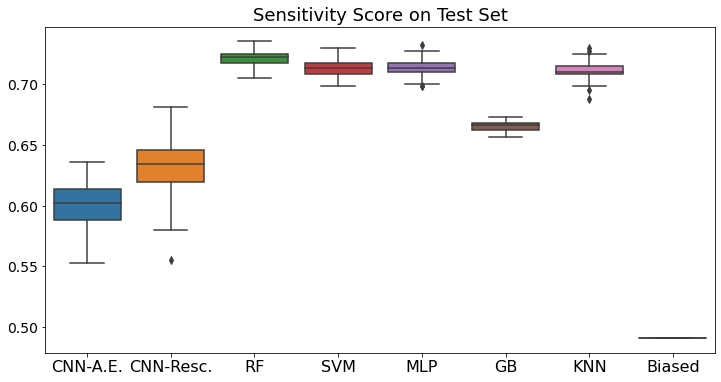

In [29]:
plt.subplots(figsize=(12,6))
sns.boxplot(data=Sensitivity)
plt.title('Sensitivity Score on Test Set',fontsize = 18)
# plt.xlabel("Classifiers", fontsize = 14)
# plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

In [30]:
c = 'test_specificity_weighed'
df = [CNN_A_E_Details,CNN_Rescaled_Details,RF_Details_CV,SVM_Details_CV,MLP_Details_CV,GB_Details_CV,KNN_Details_CV,Biased_Details_CV]
clss_name = ['CNN-A.E.','CNN-Resc.','RF','SVM','MLP','GB','KNN','Biased']
df_0 = pd.DataFrame()
for i in range(0, len(df)):
    df_00 = pd.DataFrame(df[i][c].values, columns=[clss_name[i]])
    df_0 = pd.concat([df_0,df_00],axis=1)

specificity = df_0

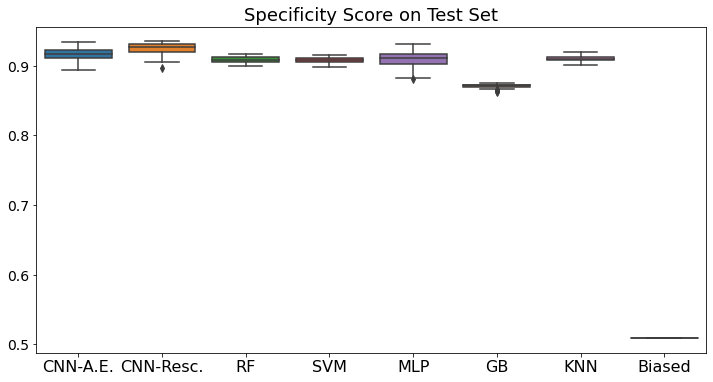

In [31]:
plt.subplots(figsize=(12,6))
sns.boxplot(data=specificity)
plt.title('Specificity Score on Test Set',fontsize = 18)
# plt.xlabel("Classifiers", fontsize = 14)
# plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()